In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [80]:
df = pd.read_csv(r'C:\Users\Thyana De Lara\Documents\TCC\modelo_vendas_forecasting\versao_2\1.dados_tratado.csv')

In [81]:
df['date'] = pd.to_datetime(df['date'])

df_start = df.date.min().date()
df_end = df.date.max().date()


print("="*25)
print("Informações Básicas da Base de Dados")
print("="*25)

print(f"Número de tipos de produtos      : {df.family.nunique()}")
print(f"Número de lojas            : {df.store_nbr.nunique()}")
print(f"Número de combinações Loja + Família: {df.groupby(["store_nbr", "family"]).ngroups}")
print(f"Número de séries temporais (targets)        : {df.groupby(["store_nbr", "family"]).ngroups}\n")

print(f"Número de datas únicas no treino: {df.date.nunique()}")
print(f"Período do treino             : {df.date.min().date()} até {df.date.max().date()}")

print(f"Total de linhas antes filtro: {len(df)}")
print(f"Custo total: {df['sales'].sum():,.2f}")
print(f"Promoções total: {df['onpromotion'].sum():,.2f}")


Informações Básicas da Base de Dados
Número de tipos de produtos      : 33
Número de lojas            : 54
Número de combinações Loja + Família: 1782
Número de séries temporais (targets)        : 1782

Número de datas únicas no treino: 56
Período do treino             : 2013-01-01 até 2017-08-01
Total de linhas antes filtro: 99792
Custo total: 1,073,645,188.79
Promoções total: 7,810,622.00


In [82]:
print("\nInformações do DataFrame:")
print(df.info())
print("\nContagem de valores nulos por coluna:")
print(df.isnull().sum())


Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99792 entries, 0 to 99791
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               99792 non-null  datetime64[ns]
 1   store_nbr          99792 non-null  int64         
 2   family             99792 non-null  object        
 3   sales              99792 non-null  float64       
 4   onpromotion        99792 non-null  int64         
 5   ano                99792 non-null  int64         
 6   mes                99792 non-null  int64         
 7   qtd_feriados       99792 non-null  float64       
 8   dias_ativos_venda  99792 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(4), object(1)
memory usage: 6.9+ MB
None

Contagem de valores nulos por coluna:
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
ano                 

In [83]:
print("\nEstatísticas descritivas:")
print(df.describe())


Estatísticas descritivas:
                                date     store_nbr          sales  \
count                          99792  99792.000000   99792.000000   
mean   2015-04-16 23:08:34.285714176     27.500000   10758.830255   
min              2013-01-01 00:00:00      1.000000       0.010000   
25%              2014-02-22 00:00:00     14.000000       5.000000   
50%              2015-04-16 00:00:00     27.500000     370.000000   
75%              2016-06-08 12:00:00     41.000000    6147.000000   
max              2017-08-01 00:00:00     54.000000  473316.000000   
std                              NaN     15.585862   31388.924268   

        onpromotion           ano           mes  qtd_feriados  \
count  99792.000000  99792.000000  99792.000000  99792.000000   
mean      78.269020   2014.857143      6.214286      2.832672   
min        0.000000   2013.000000      1.000000      0.000000   
25%        0.000000   2014.000000      3.000000      0.000000   
50%        0.000000   2015

## Coluna de agregação da familia por top 6 tipo de produto

In [84]:
# Identificar as 6 famílias com maior volume total de vendas
top6_families = df.groupby('family')['sales'].sum().sort_values(ascending=False).head(6).index.tolist()

# Criar coluna com Top 6 + "Outros"
df['family_top6'] = df['family'].apply(lambda x: x if x in top6_families else 'Outros')


## Análise da média e total de vendas por tipo de produto

Comparação entre: o volume total de vendas por família e o volume médio de vendas por loja. Observou-se que, a partir de 2016, embora a média de vendas por loja/família tenha aumentado, o volume total de vendas caiu. Isso indica que, apesar das lojas estarem vendendo mais por item, houve uma redução no número de lojas ou na frequência de vendas por combinação, o que impactou negativamente o total geral.

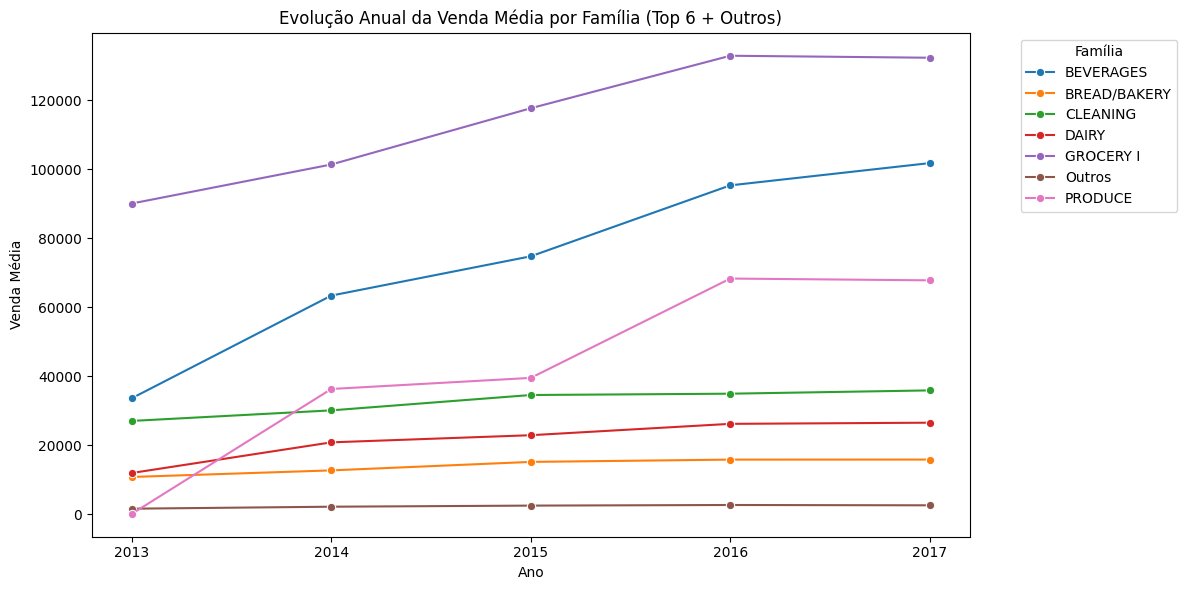

In [85]:
# Agrupar por ano e família (Top 6 + Outros), tirando a média das vendas no ano
df_grouped_ano = df.groupby(['ano', 'family_top6'])['sales'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_grouped_ano, x='ano', y='sales', hue='family_top6', marker='o')
plt.title('Evolução Anual da Venda Média por Família (Top 6 + Outros)')
plt.xlabel('Ano')
plt.ylabel('Venda Média')
plt.xticks(df['ano'].unique())
plt.legend(title='Família', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

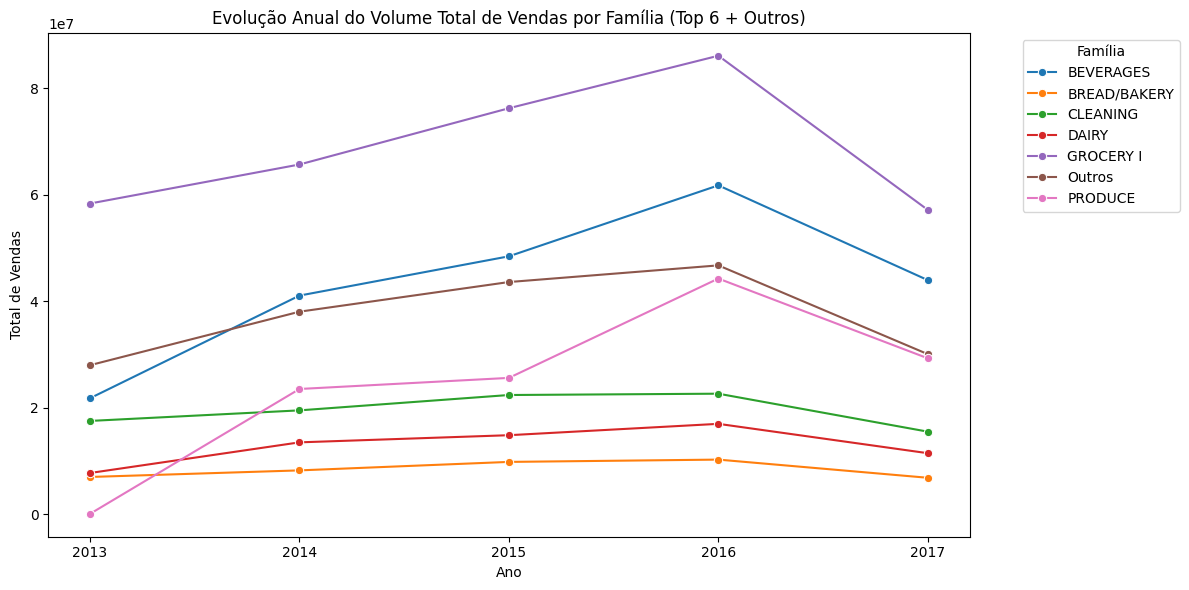

In [86]:
df_grouped_ano_total = df.groupby(['ano', 'family_top6'])['sales'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_grouped_ano_total, x='ano', y='sales', hue='family_top6', marker='o')
plt.title('Evolução Anual do Volume Total de Vendas por Família (Top 6 + Outros)')
plt.xlabel('Ano')
plt.ylabel('Total de Vendas')
plt.xticks(df['ano'].unique())
plt.legend(title='Família', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Representatividade de cada tipo de produto por ano

Nessa etapa conseguimos observar que o mix de produtos foi mudando ao longo dos anos. Produtos como GROCERY I diminuiu a representatividade enquanto o PRODUCE aumentou.

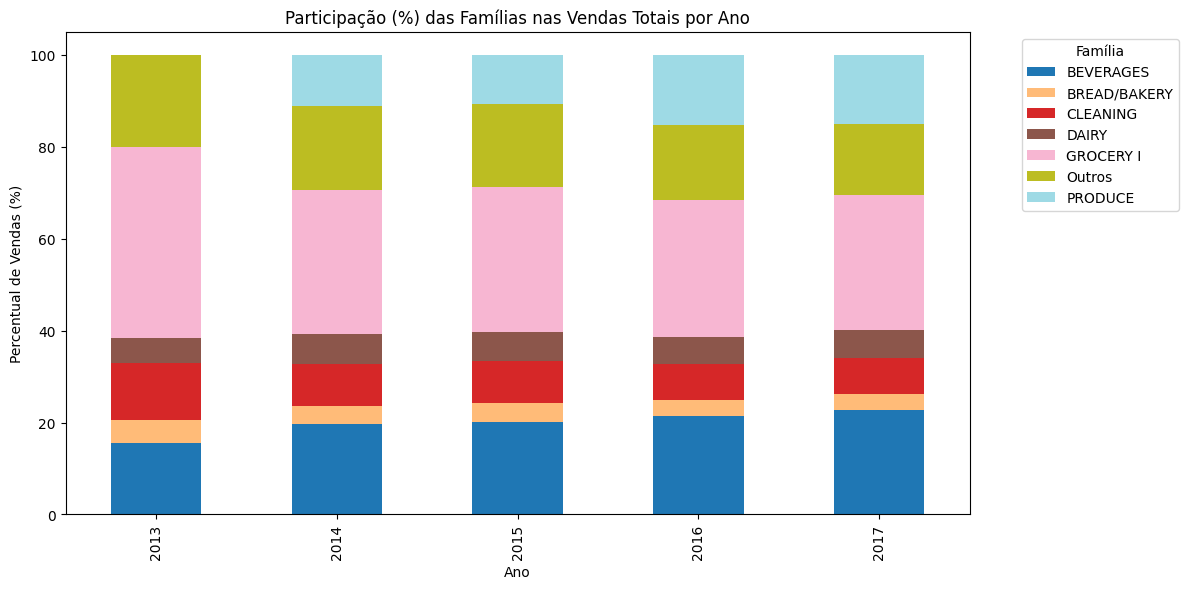

In [87]:
# Calcular o total por ano
total_por_ano = df_grouped_ano_total.groupby('ano')['sales'].transform('sum')

# Calcular a porcentagem da família dentro do ano
df_grouped_ano_total['pct'] = df_grouped_ano_total['sales'] / total_por_ano * 100

# Transformar em tabela com anos como índice e famílias como colunas
df_grouped_ano_total_pivot = df_grouped_ano_total.pivot(index='ano', columns='family_top6', values='pct').fillna(0)


# Plotar gráfico de barras empilhadas
ax = df_grouped_ano_total_pivot.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')
plt.title('Participação (%) das Famílias nas Vendas Totais por Ano')
plt.xlabel('Ano')
plt.ylabel('Percentual de Vendas (%)')
plt.legend(title='Família', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Detecção de Outliers

Foram realizadas duas rodadas de **Detecção de Outliers** que resultou na retirada de 5.61% da base original

In [88]:
# Agrupamento de ano e mês
df['ano_mes'] = pd.to_datetime(df[['ano', 'mes']].rename(columns={'ano': 'year', 'mes': 'month'}).assign(day=1)) 
df = df[~((df['ano'] == 2017) & (df['mes'] == 8))]

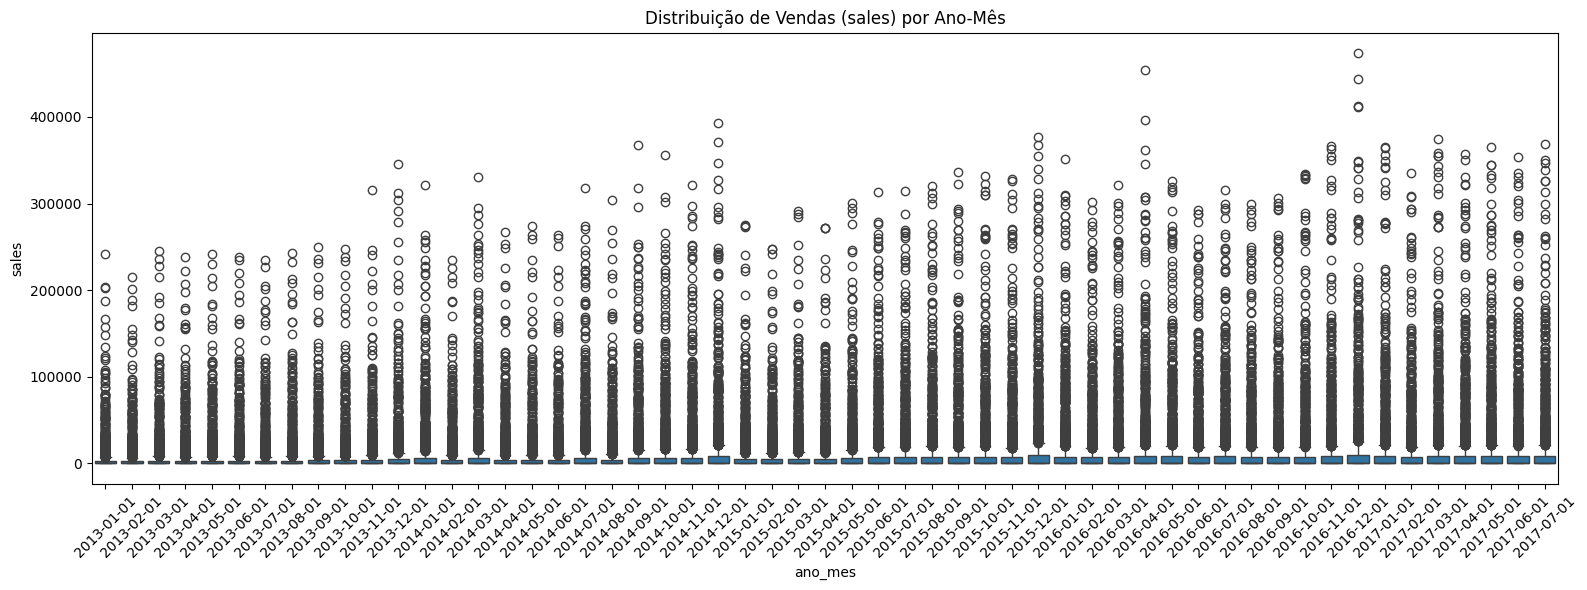

In [89]:
plt.figure(figsize=(16, 6))
sns.boxplot(x='ano_mes', y='sales', data=df)
plt.xticks(rotation=45)
plt.title('Distribuição de Vendas (sales) por Ano-Mês')
plt.tight_layout()
plt.show()

In [90]:
# Identificação dos outliers da primeira rodada

def identificar_outliers_zscore(serie, threshold=3):
    z_scores = (serie - serie.mean()) / serie.std()
    return np.abs(z_scores) > threshold

df['outlier'] = identificar_outliers_zscore(df['sales'])

outlier_stats = df.groupby('ano_mes').agg(
    total=('sales', 'count'),
    outliers=('outlier', 'sum')
).reset_index()

outlier_stats['pct_outlier'] = (outlier_stats['outliers'] / outlier_stats['total']) * 100


In [91]:
# Qtd de outlier e percentual de representatividade
total_outliers = outlier_stats['outliers'].sum()
total_registros = outlier_stats['total'].sum()
pct_geral_outlier = (total_outliers / total_registros) * 100

print(f'Total de registros: {total_registros:,}')
print(f'Total de outliers: {total_outliers:,}')
print(f'Percentual geral de outliers: {pct_geral_outlier:.2f}%')
print(outlier_stats[['ano_mes', 'pct_outlier']])

Total de registros: 98,010
Total de outliers: 2,258
Percentual geral de outliers: 2.30%
      ano_mes  pct_outlier
0  2013-01-01     0.729517
1  2013-02-01     0.617284
2  2013-03-01     0.953984
3  2013-04-01     0.897868
4  2013-05-01     0.897868
5  2013-06-01     0.953984
6  2013-07-01     1.010101
7  2013-08-01     1.066218
8  2013-09-01     1.010101
9  2013-10-01     1.010101
10 2013-11-01     1.066218
11 2013-12-01     1.627385
12 2014-01-01     2.188552
13 2014-02-01     0.953984
14 2014-03-01     2.413019
15 2014-04-01     1.178451
16 2014-05-01     1.290685
17 2014-06-01     1.234568
18 2014-07-01     2.244669
19 2014-08-01     1.346801
20 2014-09-01     2.356902
21 2014-10-01     2.413019
22 2014-11-01     2.413019
23 2014-12-01     3.198653
24 2015-01-01     1.402918
25 2015-02-01     1.122334
26 2015-03-01     1.795735
27 2015-04-01     1.627385
28 2015-05-01     2.020202
29 2015-06-01     2.693603
30 2015-07-01     2.918070
31 2015-08-01     2.918070
32 2015-09-01     3.0

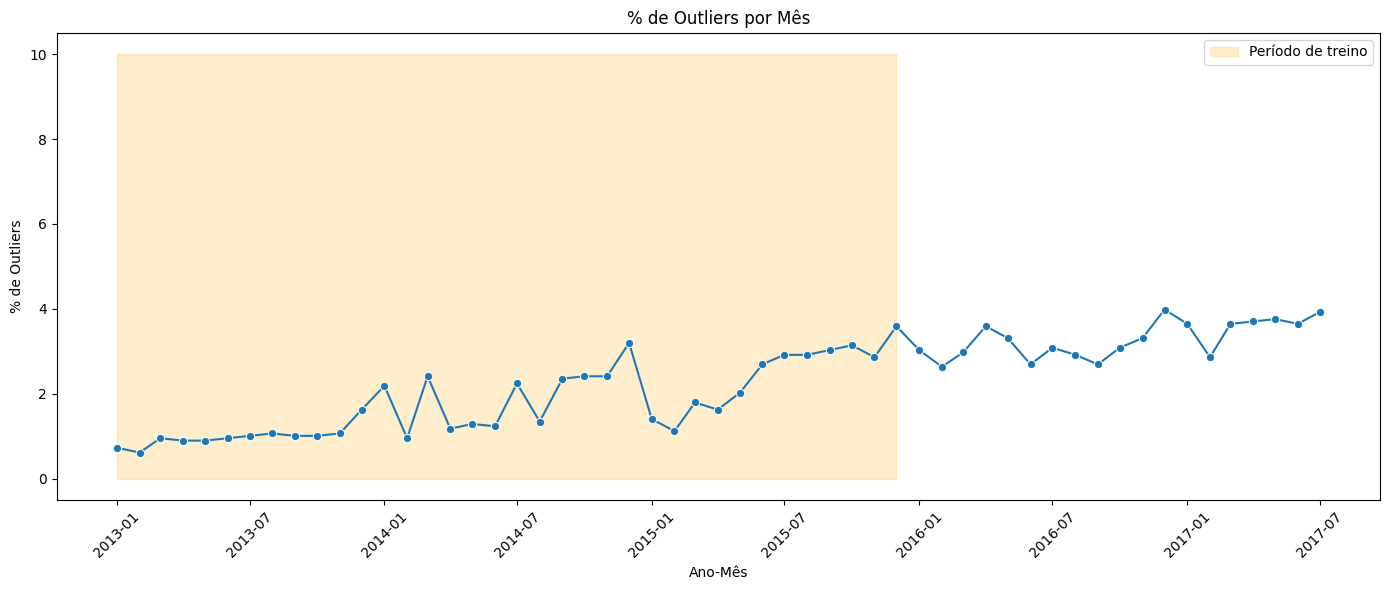

In [92]:
plt.figure(figsize=(14,6))
sns.lineplot(data=outlier_stats, x='ano_mes', y='pct_outlier', marker='o')
plt.fill_between(outlier_stats['ano_mes'], 0, 10, where=(outlier_stats['ano_mes'] < '2016-01-01'), color='orange', alpha=0.2, label='Período de treino')
plt.title('% de Outliers por Mês')
plt.xlabel('Ano-Mês')
plt.ylabel('% de Outliers')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [93]:
# Separar os outliers
df_outliers = df[df['outlier']].copy()

# Separar a base sem os outliers
df_sem_outliers = df[~df['outlier']].copy()

# Verificar o resumo
print(f"Base original     : {df.shape[0]:,} linhas")
print(f"Sem outliers      : {df_sem_outliers.shape[0]:,} linhas")
print(f"Apenas outliers   : {df_outliers.shape[0]:,} linhas ({df_outliers.shape[0]/df.shape[0]*100:.2f}%)")


Base original     : 98,010 linhas
Sem outliers      : 95,752 linhas
Apenas outliers   : 2,258 linhas (2.30%)


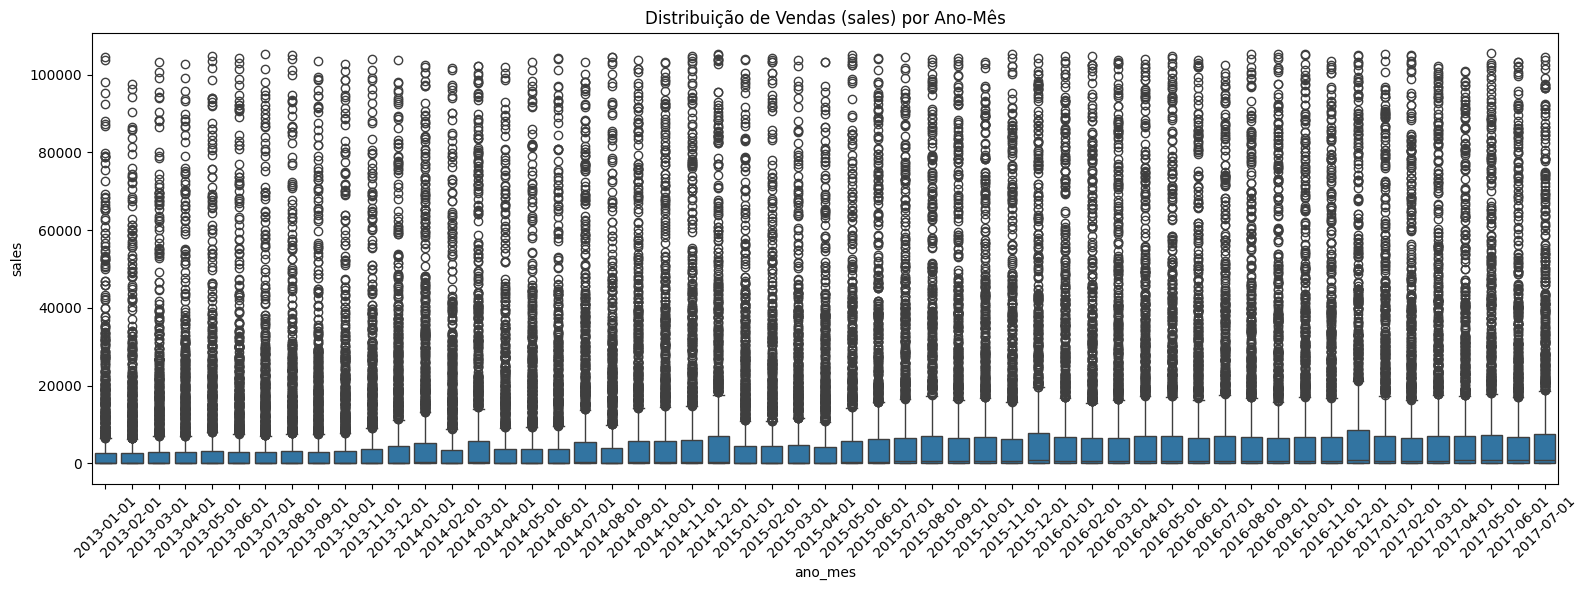

In [94]:
plt.figure(figsize=(16, 6))
sns.boxplot(x='ano_mes', y='sales', data=df_sem_outliers)
plt.xticks(rotation=45)
plt.title('Distribuição de Vendas (sales) por Ano-Mês')
plt.tight_layout()
plt.show()

In [95]:
df_sem_outliers['outlier'] = identificar_outliers_zscore(df_sem_outliers['sales'])

outlier_stats2 = df_sem_outliers.groupby('ano_mes').agg(total=('sales', 'count'),outliers=('outlier', 'sum')).reset_index()

outlier_stats2['pct_outlier'] = (outlier_stats2['outliers'] / outlier_stats2['total']) * 100


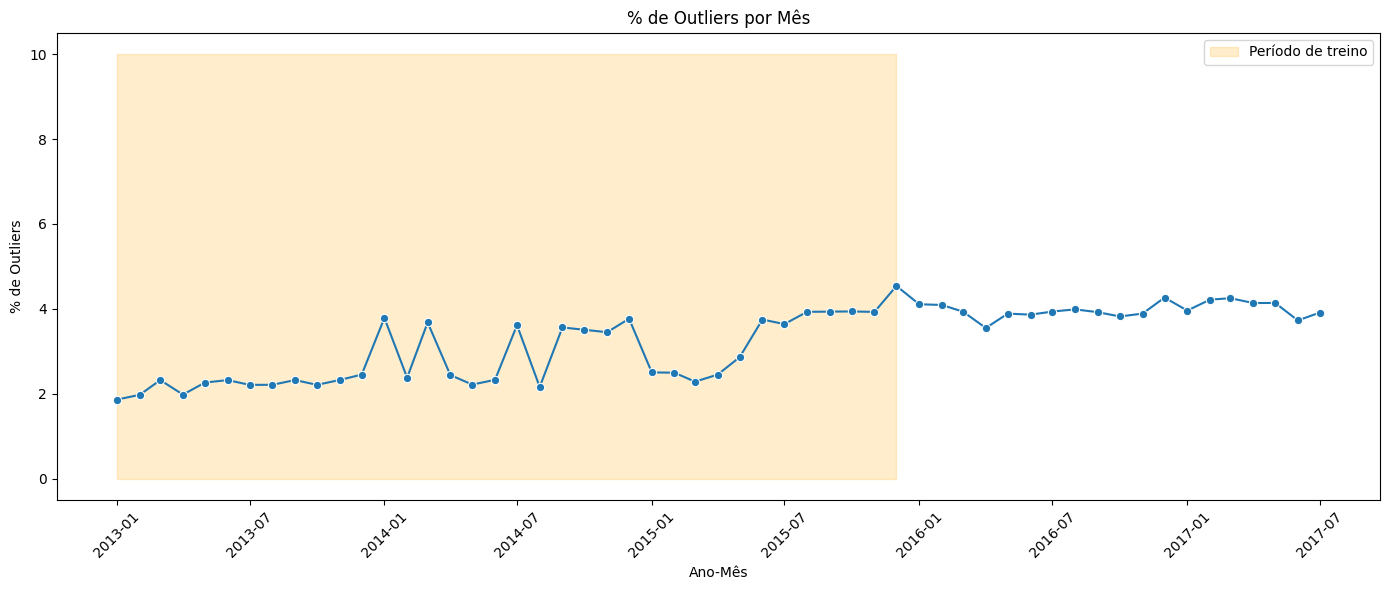

In [96]:
plt.figure(figsize=(14,6))
sns.lineplot(data=outlier_stats2, x='ano_mes', y='pct_outlier', marker='o')
plt.fill_between(outlier_stats2['ano_mes'], 0, 10, where=(outlier_stats2['ano_mes'] < '2016-01-01'), color='orange', alpha=0.2, label='Período de treino')
plt.title('% de Outliers por Mês')
plt.xlabel('Ano-Mês')
plt.ylabel('% de Outliers')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [97]:
# Outliers da segunda rodada
df_outliers_2 = df_sem_outliers[df_sem_outliers['outlier']].copy()

# Atualizar o DataFrame df_outliers empilhando os novos
df_outliers = pd.concat([df_outliers, df_outliers_2], ignore_index=True)

# Atualizar a base final sem outliers
df_sem_outliers2 = df_sem_outliers[~df_sem_outliers['outlier']].copy()

# Verificar o resumo atualizado
print(f"Base antes 2ª rodada: {df_sem_outliers.shape[0]:,} linhas")
print(f"Sem outliers        : {df_sem_outliers2.shape[0]:,} linhas")
print(f"Total outliers  2ª rodada    : {df_outliers.shape[0]:,} linhas ({df_outliers.shape[0]/df_sem_outliers.shape[0]*100:.2f}%)")


Base antes 2ª rodada: 95,752 linhas
Sem outliers        : 92,639 linhas
Total outliers  2ª rodada    : 5,371 linhas (5.61%)


C:\Users\Thyana De Lara\AppData\Local\Temp\ipykernel_14392\3291224594.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_mensal, x='mes', y='sales', palette='viridis')


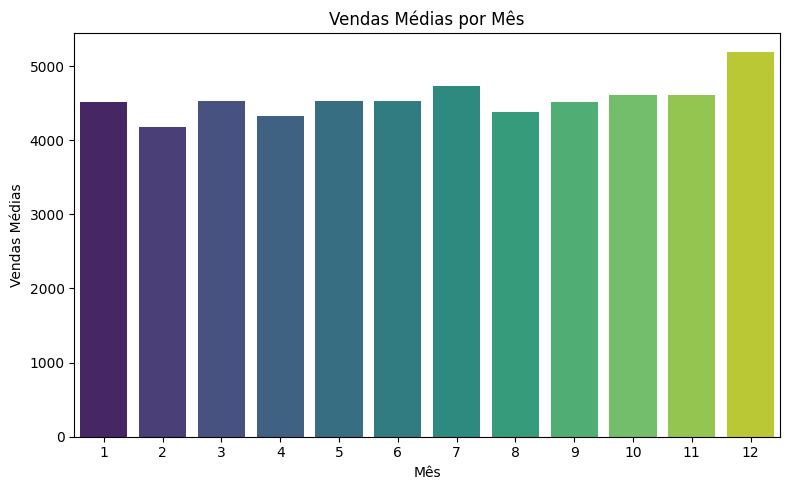

In [98]:
# Agrupar vendas por mês
df_mensal = df_sem_outliers2.groupby('mes')['sales'].mean().reset_index()

# Histograma das médias mensais
plt.figure(figsize=(8, 5))
sns.barplot(data=df_mensal, x='mes', y='sales', palette='viridis')
plt.title('Vendas Médias por Mês')
plt.xlabel('Mês')
plt.ylabel('Vendas Médias')
plt.xticks(range(0,12), [str(i+1) for i in range(12)])
plt.tight_layout()
plt.show()


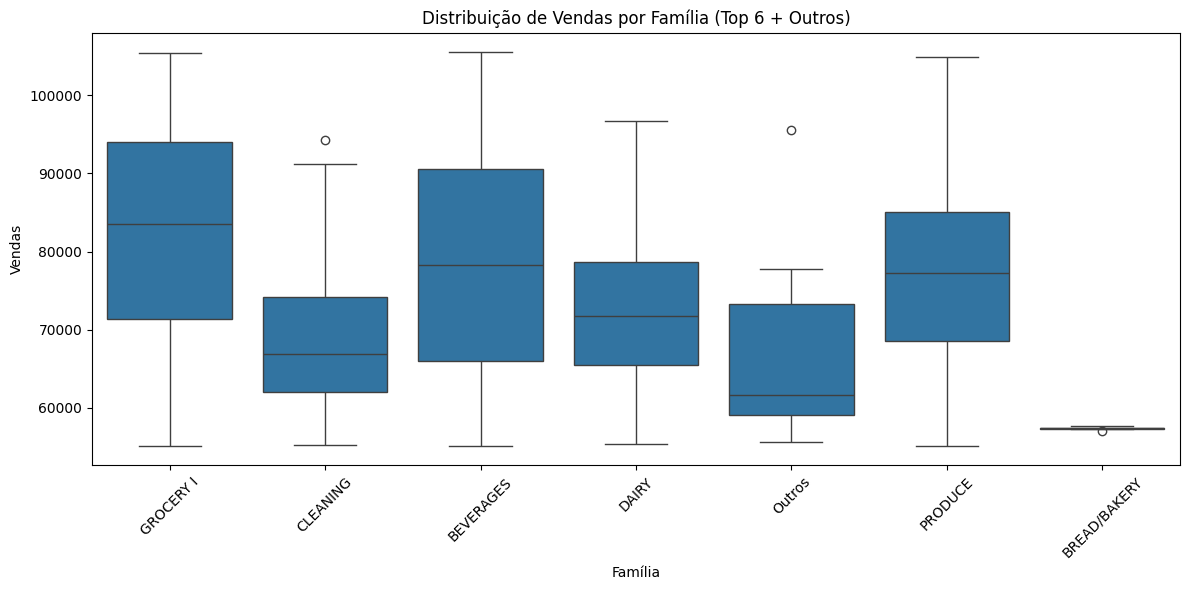

In [99]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_outliers_2, x='family_top6', y='sales')
plt.title('Distribuição de Vendas por Família (Top 6 + Outros)')
plt.xlabel('Família')
plt.ylabel('Vendas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [100]:
# Exemplo: salvar em CSV se quiser
df_outliers.to_csv('2.2.outliers.csv', index=False)
df_sem_outliers2.to_csv('2.1.dados_limpos.csv', index=False)